In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters

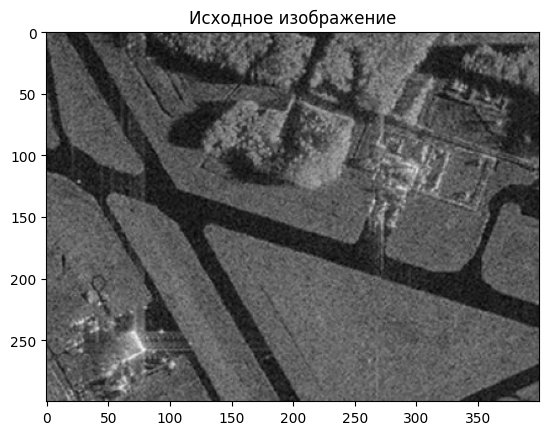

In [23]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.show()


In [24]:
# критерий однородности на основе среднего значения
def homo_average(img, mask, point, T): 
    # среднее значение в регионе:
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0]) 
    if abs(av_val - img[point]) <= T:
        return True
    return False

In [25]:
# критерий однородности на основе медианы
def homo_median(img, mask, point, T):
    if np.count_nonzero(mask) > 0:
        # вычисляем медиану значений в регионе:
        median_val = np.median(img[mask > 0])
        if abs(median_val - img[point]) <= T:
            return True
    return False

In [26]:
# алгоритм разрастания регионов
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i,j] == 0 and mask[i - r:i + r, j - r: j + r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255

# 1. Подберите параметры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

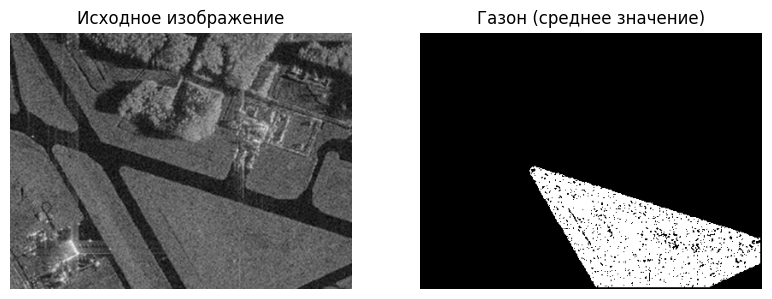

In [27]:
seed_point = (250, 250)  
mask_lawn_avg = region_growing(image_gray, seed_point, homo_average, 2, 15)  

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_gray, cmap="gray")
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Газон (среднее значение)")
plt.axis('off')

# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

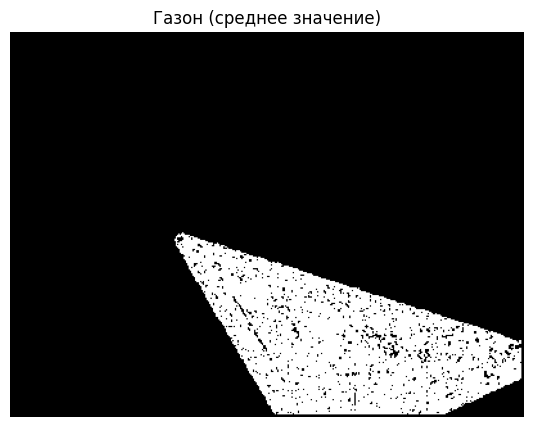

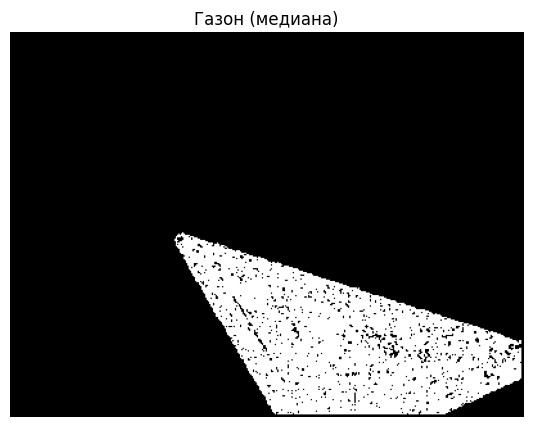

Сравнение критериев однородности:
Пикселей выделено средним: 19437
Пикселей выделено медианой: 19475


In [28]:
mask_lawn_median = region_growing(image_gray, seed_point, homo_median, 2, 15)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_lawn_avg, cmap="gray")
plt.title("Газон (среднее значение)")
plt.axis('off')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.imshow(mask_lawn_median, cmap="gray")
plt.title("Газон (медиана)")
plt.axis('off')
plt.show()

# Сравнение результатов
print("Сравнение критериев однородности:")
print(f"Пикселей выделено средним: {np.count_nonzero(mask_lawn_avg)}")
print(f"Пикселей выделено медианой: {np.count_nonzero(mask_lawn_median)}")

# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [29]:
# Загрузка изображения
palm_image = cv2.imread('palm_1.jpg') 
palm_rgb = cv2.cvtColor(palm_image, cv2.COLOR_BGR2RGB)
palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(palm_gray, (5, 5), 0) 
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


if np.mean(binary) < 128:
    binary = cv2.bitwise_not(binary)


kernel = np.ones((3,3), np.uint8)
binary_clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=3)
binary_clean = cv2.morphologyEx(binary_clean, cv2.MORPH_CLOSE, kernel, iterations=3)


num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_clean)


min_area = 20   
max_area = 5000 

palm_count = 0
result_image = palm_rgb.copy()

for i in range(1, num_labels):  
    area = stats[i, cv2.CC_STAT_AREA]
    
    if min_area < area < max_area:
        palm_count += 1
        
        # Рисуем контур пальмы
        mask = (labels == i).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(result_image, contours, -1, (0, 255, 0), 2)
        
        # Рисуем центр
        center = (int(centroids[i, 0]), int(centroids[i, 1]))
        cv2.circle(result_image, center, 3, (255, 0, 0), -1)
        
        # Подписываем номер
        cv2.putText(result_image, str(palm_count), (center[0]-10, center[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


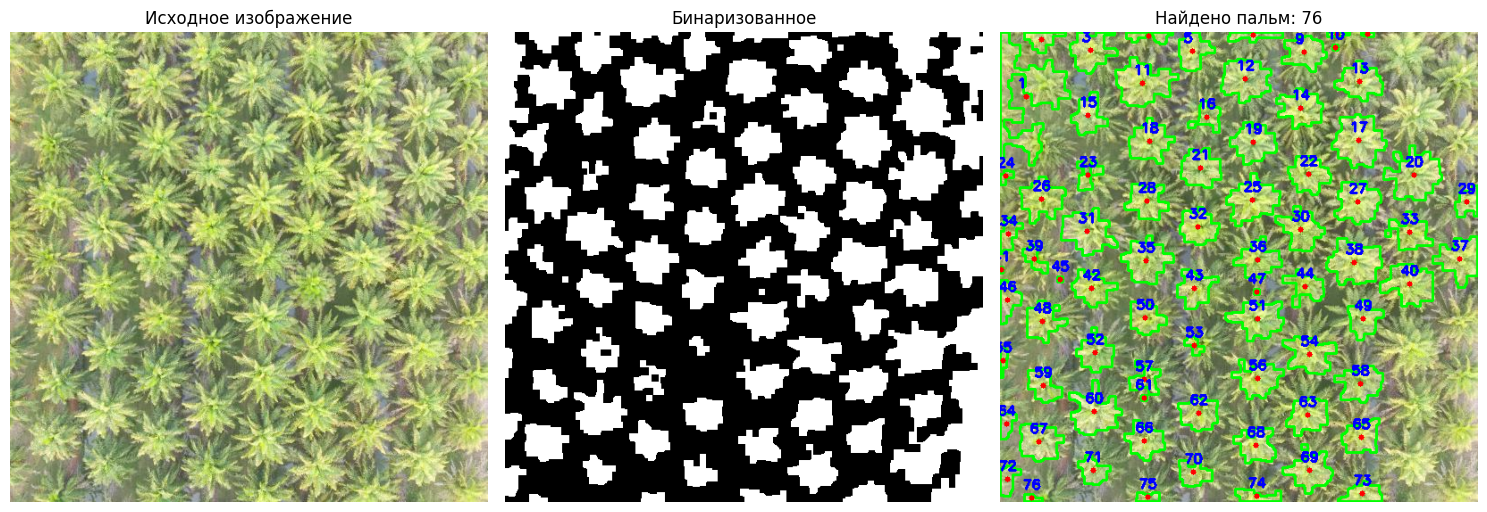

Количество пальмовых деревьев: 76


In [30]:
# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(palm_rgb)
plt.title("Исходное изображение")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_clean, cmap='gray')
plt.title("Бинаризованное")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(result_image)
plt.title(f"Найдено пальм: {palm_count}")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Количество пальмовых деревьев: {palm_count}")